# Linear regression

In [1]:
from IPython import get_ipython

if get_ipython():
    get_ipython().run_line_magic("load_ext", "autoreload")
    get_ipython().run_line_magic("autoreload", "2")

import numpy as np
import pandas as pd
import torch

import xarray as xr

import matplotlib.pyplot as plt
import seaborn as sns

import collections

import latenta as la

la.logger.setLevel("INFO")

## Generative model

In [2]:
n_cells = 50
cell_ids = [str(i) for i in range(n_cells)]
cells = la.Dim(pd.Series(cell_ids, name="cell"))

x = la.Fixed(pd.Series(np.random.uniform(0, 3, n_cells), index=cells.index), label="x")

In [3]:
n_genes = 100
genes = la.Dim([str(i) for i in range(n_genes)], name="gene")

slope = la.Fixed(
    pd.Series(
        np.random.choice([-1, 1], n_genes)
        * np.random.normal(3.0, 1.0, n_genes)
        * (np.random.random(n_genes) > 0.5),
        index=genes.index,
    ),
    label="slope",
)
intercept = la.Fixed(
    pd.Series(
        np.random.choice([-1, 1], n_genes)
        * np.random.normal(3.0, 1.0, n_genes)
        * (np.random.random(n_genes) > 0.5),
        index=genes.index,
    ),
    label="intercept",
)
scale = la.Fixed(
    pd.Series(np.random.uniform(1.0, 1.2, n_genes), index=genes.index), label="scale"
)

In [4]:
y = la.links.scalar.Linear(x=x, a=slope, b=intercept)

In [5]:
dist = la.distributions.Normal(loc=y, scale=scale, label="distribution")

In [6]:
model_gs = la.Root(dist = dist, label="ground truth", symbol="gs")
model_gs.plot()

In [7]:
posterior = la.posterior.Posterior(dist)
posterior.sample(1)

  0%|          | 0/1 [00:00<?, ?it/s]

<AxesSubplot:xlabel='gene', ylabel='cell'>

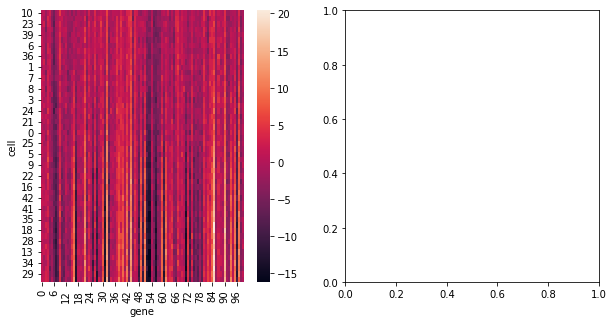

In [8]:
observation_value = posterior.samples[dist].sel(sample=0).to_pandas()
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))
cell_order = model_gs.find("x").prior_pd().sort_values().index
sns.heatmap(observation_value.loc[cell_order], ax=ax0)

## Linear regression with maximum likelihood

In [9]:
a = la.Parameter(
    0.0, definition=slope
)
b = la.Parameter(
    0.0, definition=intercept
)
s = la.Parameter(
    1.0, definition=scale, transforms=[la.transforms.Exp()]
)

z = la.links.scalar.Linear(x, a, b)

dist = la.distributions.Normal(loc=z, scale=s)

observation = la.Observation(observation_value, dist, label="observation")

In [10]:
model = la.Root(observation = observation)
model.plot()

  0%|                                                                                                         …

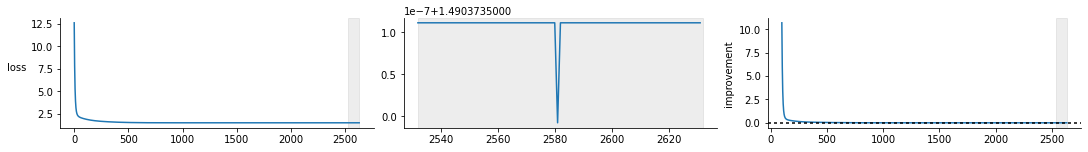

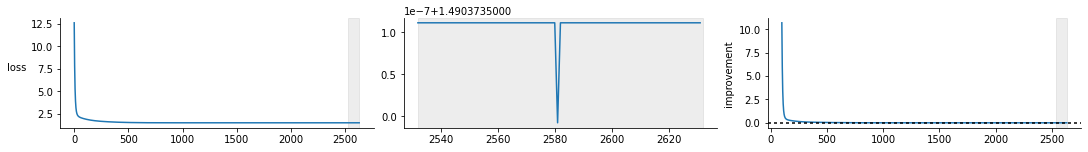

In [11]:
inference = la.infer.svi.SVI(
    model, [la.infer.loss.ELBO()], la.infer.optim.Adam(lr=0.05)
)
trainer = la.infer.trainer.Trainer(inference)
trace = trainer.train(3000)
trace.plot()

In [12]:
observed = la.posterior.Posterior(
    observation, retain_samples={observation.p, a, b, s, x}
)
observed.sample(10, subsample_n=1)

  0%|          | 0/10 [00:00<?, ?it/s]

<AxesSubplot:xlabel='gene', ylabel='cell'>

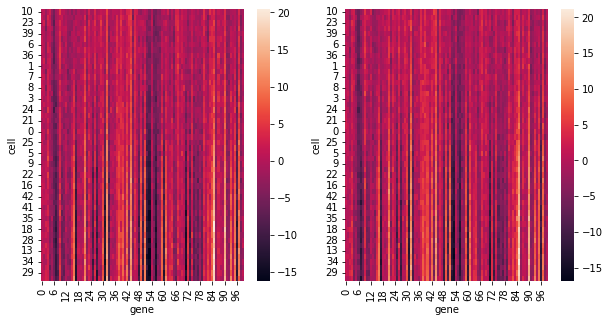

In [13]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))
cell_order = model_gs.find("x").prior_pd().sort_values().index
sns.heatmap(observation_value.loc[cell_order], ax=ax0)
modelled_value = observed.samples[observation.p].sel(sample=0).to_pandas()
sns.heatmap(modelled_value.loc[cell_order], ax=ax1)

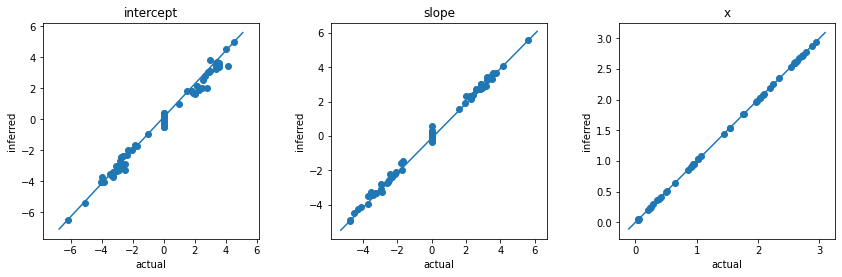

In [14]:
parameter_values = la.qa.cookbooks.check_parameters(
    la.qa.cookbooks.gather_parameters(["intercept", "slope", "x"], model_gs, observed)
)

## Linear regression with maximal likelihood and inferred x

In [15]:
x = la.Parameter(
    0.5,
    definition=x,
    transforms=la.distributions.Uniform(0.0, 1.0).biject_to(),
    label="x",
)

In [16]:
a = la.Parameter(
    0.0, definition=slope, transforms=la.distributions.Normal(scale=1.0).biject_to()
)
b = la.Parameter(
    0.0, definition=intercept, transforms=la.distributions.Normal(scale=1.0).biject_to()
)
s = la.Parameter(
    1.0, definition=scale, transforms=la.distributions.Exponential().biject_to()
)

z = la.links.scalar.Linear(x, a, b)

dist = la.distributions.Normal(loc=z, scale=s)

observation = la.Observation(observation_value, dist, label="observation")

In [17]:
model = la.Root(observation = observation)
model.plot()

  0%|                                                                                                         …

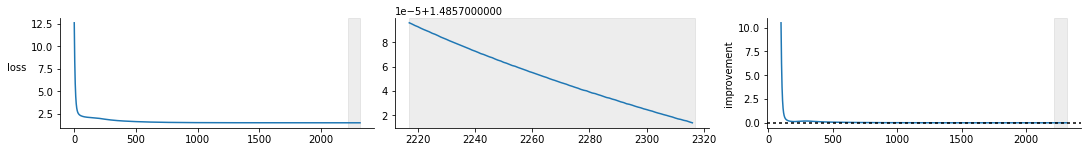

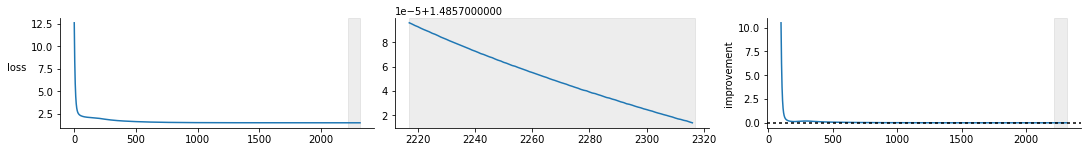

In [18]:
inference = la.infer.svi.SVI(
    model, [la.infer.loss.ELBO()], la.infer.optim.Adam(lr=0.05)
)
trainer = la.infer.trainer.Trainer(inference)
trace = trainer.train(3000)
trace.plot()

In [19]:
observed = la.posterior.Posterior(
    observation, retain_samples={observation.p, a, b, s, x}
)
observed.sample(10, subsample_n=3)

  0%|          | 0/10 [00:00<?, ?it/s]

<AxesSubplot:xlabel='gene', ylabel='cell'>

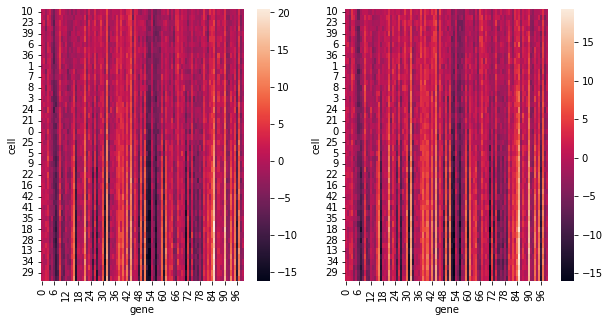

In [20]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))
cell_order = model_gs.find("x").prior_pd().sort_values().index
sns.heatmap(observation_value.loc[cell_order], ax=ax0)
modelled_value = observed.samples[observation.p].sel(sample=0).to_pandas()
sns.heatmap(modelled_value.loc[cell_order], ax=ax1)

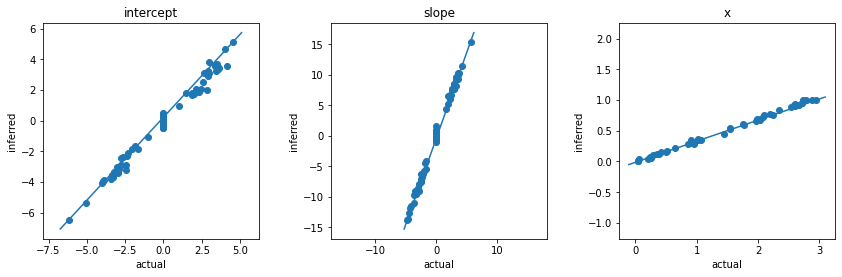

In [21]:
parameter_values = la.qa.cookbooks.check_parameters(
    la.qa.cookbooks.gather_parameters(["intercept", "slope", "x"], model_gs, observed)
)

## Linear regression with variational inference and latent x

In [22]:
x = la.Latent(
    la.distributions.Uniform(0.0, 3.0), definition=la.Definition([cells]), label="x"
)

z = la.links.scalar.Linear(x, output=la.Definition([cells, genes]), a=True, b=True)

dist = la.distributions.Normal(loc=z, scale=s)

observation = la.Observation(observation_value, dist, label="observation")

In [23]:
model = la.Root(observation = observation)
model.plot()

  0%|                                                                                                         …

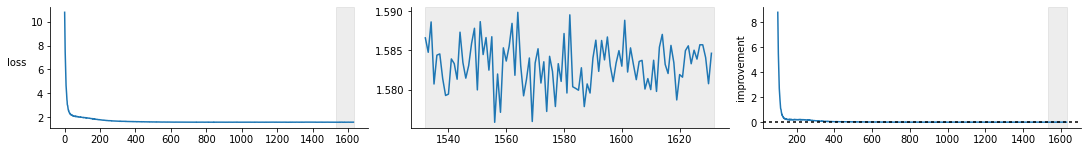

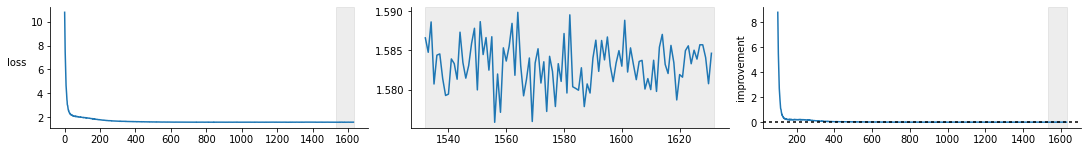

In [24]:
inference = la.infer.svi.SVI(
    model, [la.infer.loss.ELBO()], la.infer.optim.Adam(lr=0.05)
)
trainer = la.infer.trainer.Trainer(inference)
trace = trainer.train(3000)
trace.plot()

In [25]:
observation.reset()
observation.run()
observation.p.loc.x.likelihood.sum()

tensor(-54.9306)

In [26]:
observed = la.posterior.Posterior(
    observation, retain_samples={observation.p, z.a, z.b, s, x}
)
observed.sample(10, subsample_n=4)

  0%|          | 0/10 [00:00<?, ?it/s]

<AxesSubplot:xlabel='gene', ylabel='cell'>

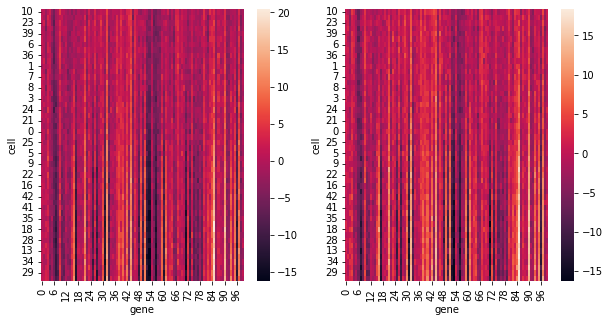

In [27]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))
cell_order = model_gs.find("x").prior_pd().sort_values().index
sns.heatmap(observation_value.loc[cell_order], ax=ax0)
modelled_value = observed.samples[observation.p].sel(sample=0).to_pandas()
sns.heatmap(modelled_value.loc[cell_order], ax=ax1)

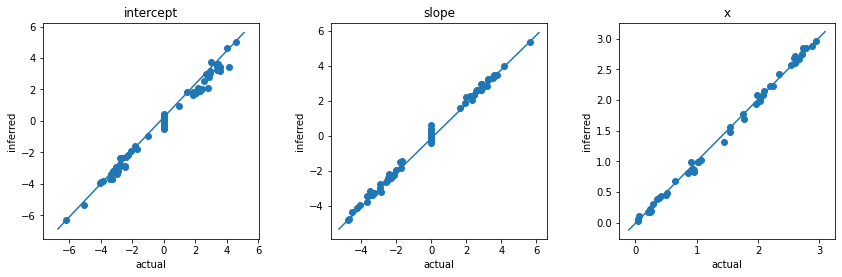

In [28]:
parameter_values = la.qa.cookbooks.check_parameters(
    la.qa.cookbooks.gather_parameters(["intercept", "slope", "x"], model_gs, observed)
)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

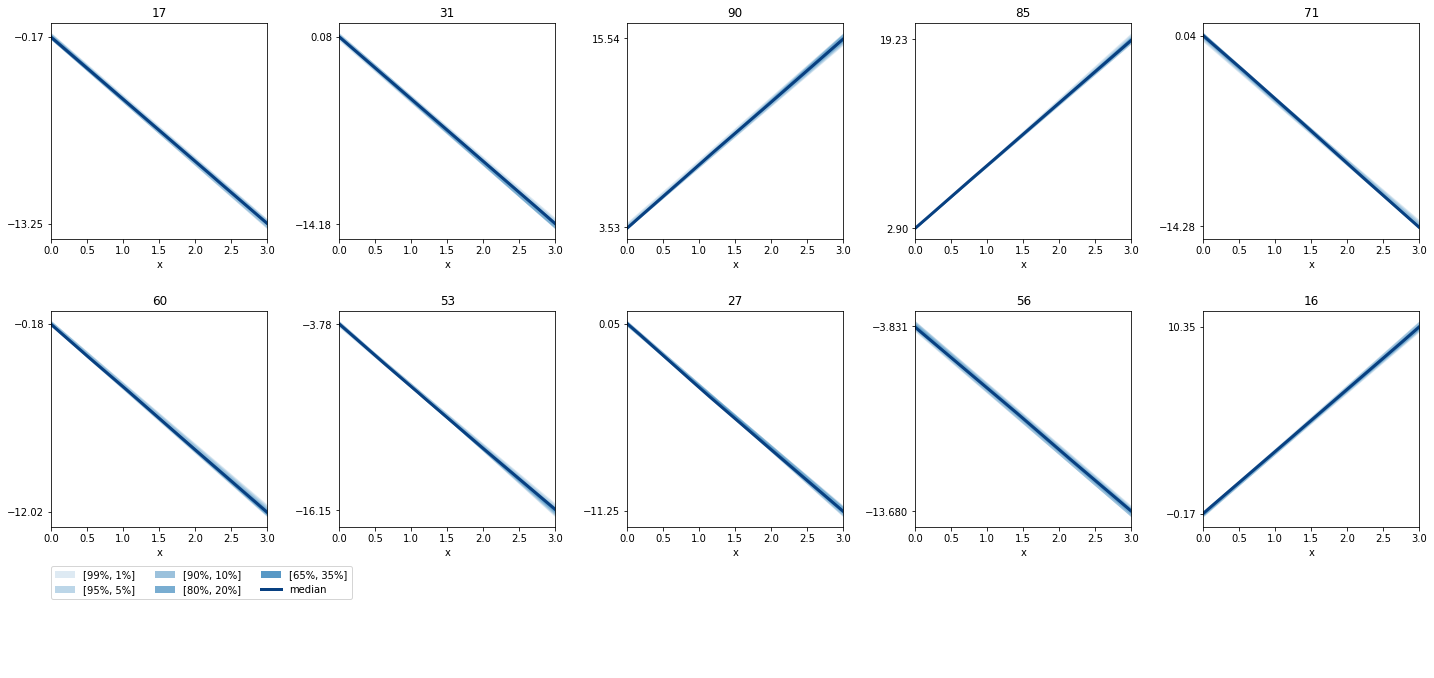

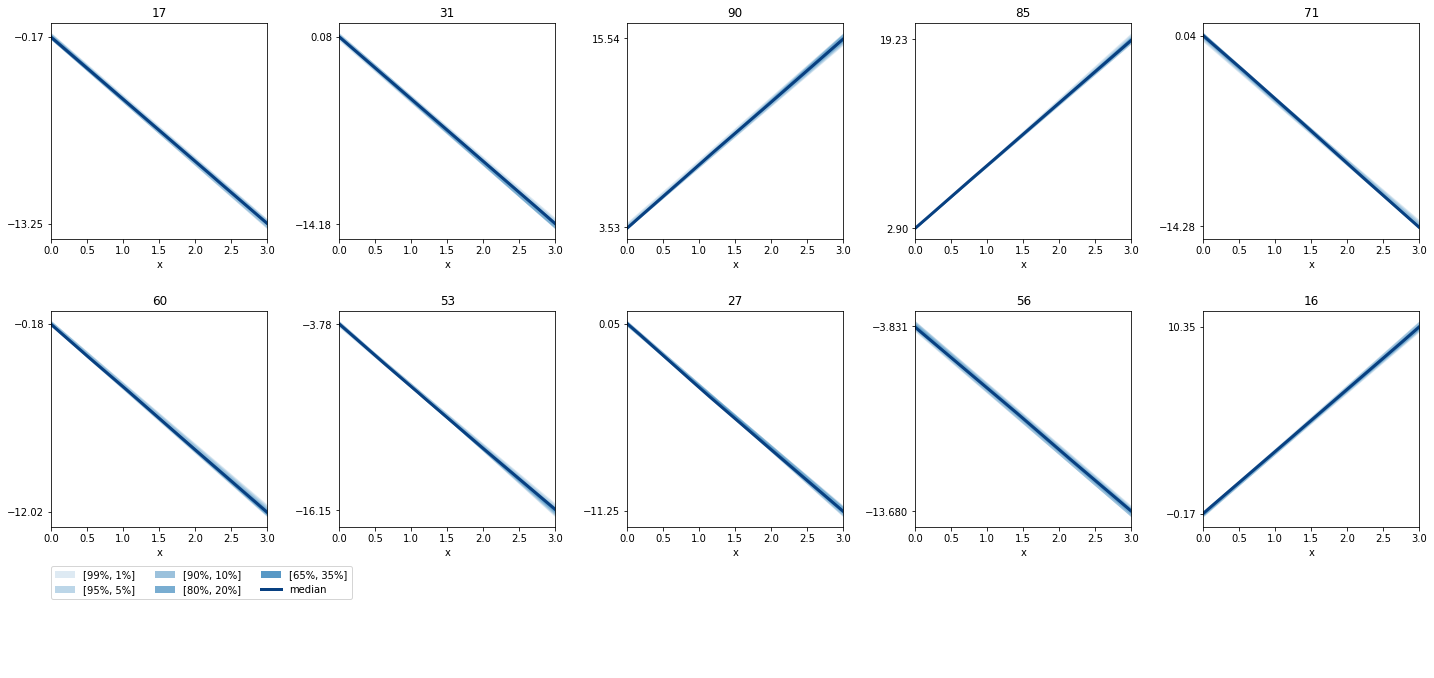

In [29]:
z.empirical = xr.DataArray(observation_value)
x.distribution = la.distributions.Uniform(0.0, 3.0)
causal = la.posterior.scalar.ScalarVectorCausal(x, observation, observed=observed)
causal.sample(10)
causal.sample_random(10)
causal.plot_features(observation.p.loc)

## Linear regression with variational inference and amortized latent x

In [30]:
amortization_input = la.Fixed(observation_value, label="observed")
nn = la.amortization.Encoder(amortization_input, x)

In [31]:
model = la.Root(observation = observation)
model.plot()

  0%|                                                                                                         …

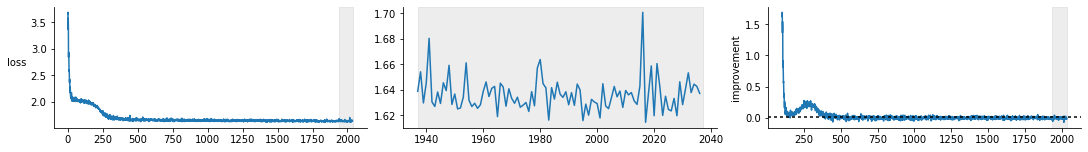

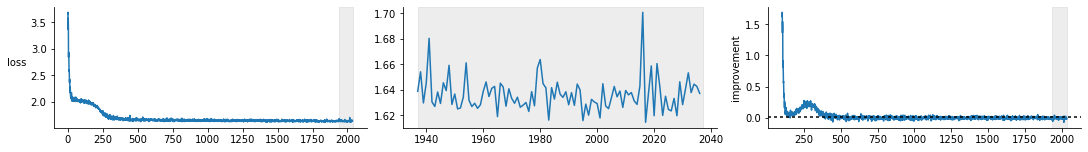

In [32]:
inference = la.infer.svi.SVI(
    model, [la.infer.loss.ELBO()], la.infer.optim.Adam(lr=0.05)
)
trainer = la.infer.trainer.Trainer(inference)
trace = trainer.train(3000)
trace.plot()

In [33]:
observed = la.posterior.Posterior(
    observation, retain_samples={observation.p, z.a, z.b, s, x}
)
observed.sample(10, subsample_n=3)

  0%|          | 0/10 [00:00<?, ?it/s]

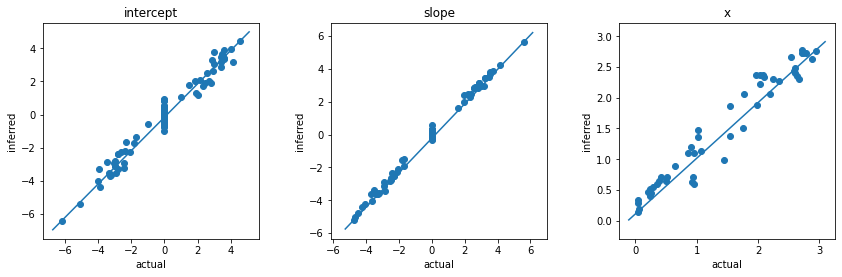

In [34]:
parameter_values = la.qa.cookbooks.check_parameters(
    la.qa.cookbooks.gather_parameters(["intercept", "slope", "x"], model_gs, observed)
)

<AxesSubplot:xlabel='gene', ylabel='cell'>

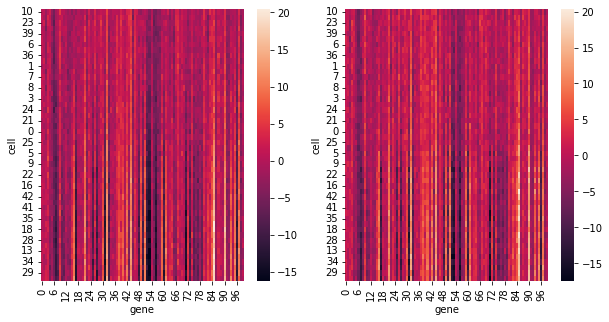

In [35]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))
cell_order = model_gs.find("x").prior_pd().sort_values().index
sns.heatmap(observation_value.loc[cell_order], ax=ax0)
modelled_value = observed.samples[observation.p].sel(sample=0).to_pandas()
sns.heatmap(modelled_value.loc[cell_order], ax=ax1)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

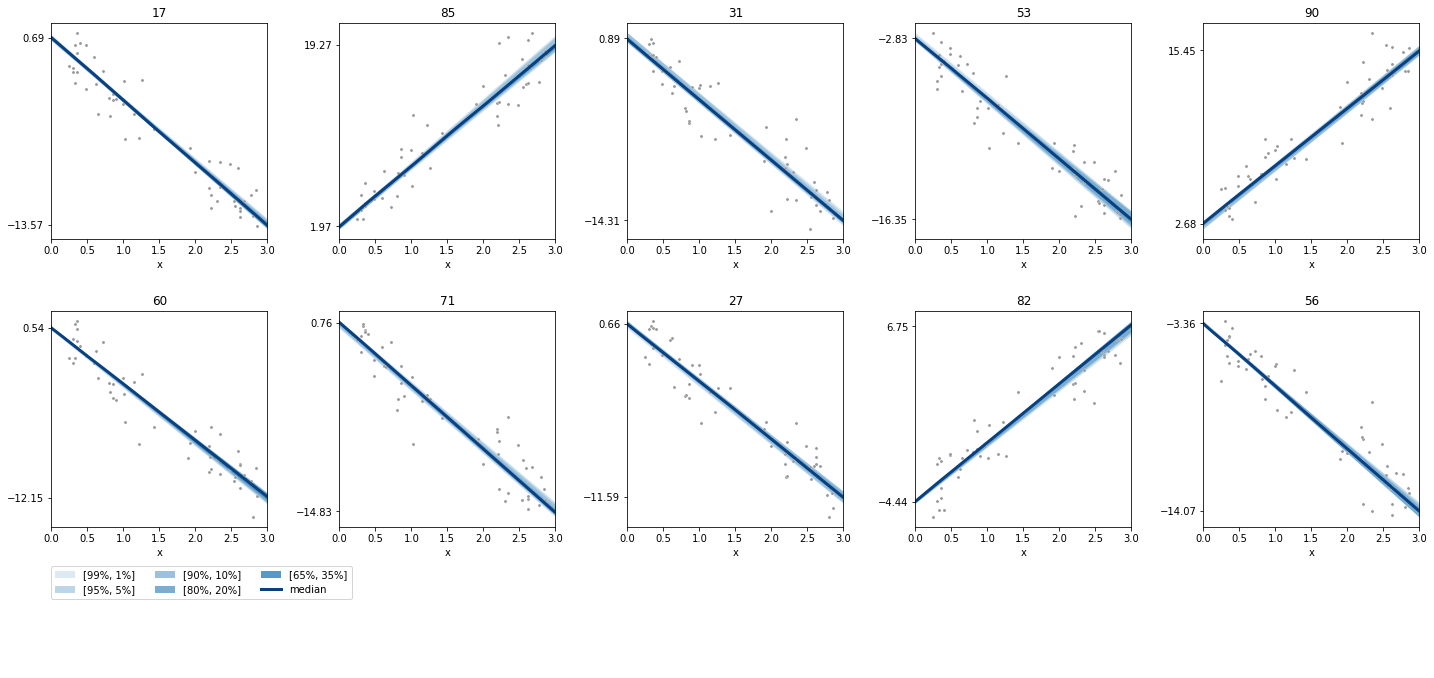

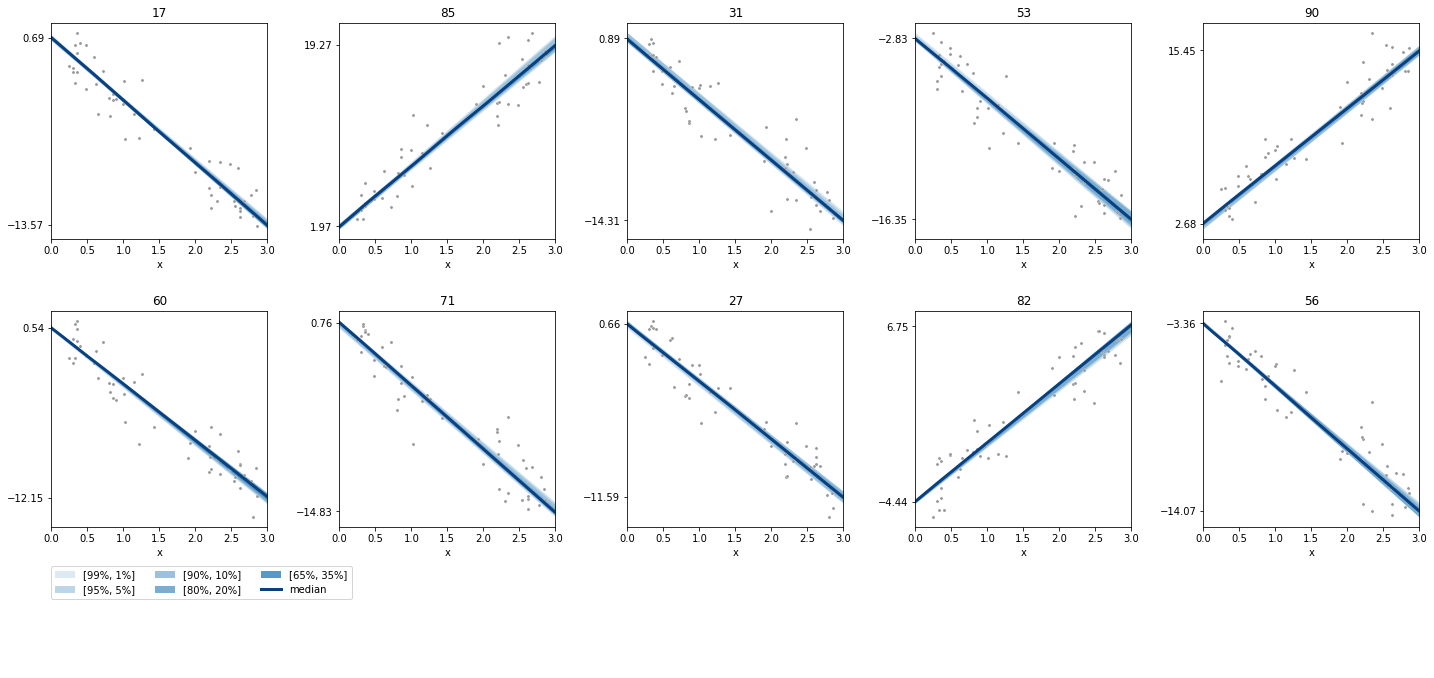

In [36]:
z.empirical = xr.DataArray(observation_value)
x.distribution = la.distributions.Uniform(0.0, 3.0)
causal = la.posterior.scalar.ScalarVectorCausal(x, observation, observed=observed)
causal.sample(10)
causal.sample_random(10)
causal.sample_empirical()
causal.plot_features()